In [97]:
import os, sys
import pandas as pd
from eval import (
    per_gene_correlation,
    plot_per_gene_correlation_scatterplot,
    plot_gene_correlation_distribution,
    train_classifier
)

sys.path.append("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/")
from grn_inference import utils
from plotting import (
    plot_auroc
)
from transformer_training import (
    prepare_dataloader,
    
)
import matplotlib.pyplot as plt

selected_date = "26_09_14_28_17"
PROJECT_DIR="/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
TRANSFORMER_DATA_DIR = os.path.join(PROJECT_DIR, "dev/transformer/transformer_data")

TEST_DIR=os.path.join(PROJECT_DIR, f"output/transformer_testing_output/model_training_{selected_date}")

DATA_DIR = os.path.join(PROJECT_DIR, "dev/transformer/transformer_data")
GROUND_TRUTH_FILE = os.path.join(PROJECT_DIR, "ground_truth_files/mESC_beeline_ChIP-seq.csv")

In [99]:
iter_log_dict = {}
for item in os.listdir(TEST_DIR):
    item_path = os.path.join(TEST_DIR, item)
    if os.path.isdir(item_path) and "iter" in item:
        print(item)
        iter_training_log_path = os.path.join(item_path, "training_log.csv")
        if os.path.isfile(iter_training_log_path):
            iter_training_log_df = pd.read_csv(iter_training_log_path, index_col=0, header=0)
            iter_log_dict[item] = iter_training_log_df



iter3
iter1
iter2


In [104]:
gene_near_peaks_df = pd.read_parquet("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/transformer/transformer_data/genes_near_peaks_chr19.parquet")
print(gene_near_peaks_df.head())

       peak_chr  peak_start  peak_end                  peak_id gene_chr  \
146647    chr19    32387451  32388051  chr19:32387451-32388051    chr19   
188509    chr19    44756302  44756902  chr19:44756302-44756902    chr19   
176071    chr19    42779374  42779974  chr19:42779374-42779974    chr19   
80777     chr19     6941265   6941865    chr19:6941265-6941865    chr19   
224759    chr19    53142146  53142746  chr19:53142146-53142746    chr19   

        gene_start  gene_end target_id  TSS_dist  TSS_dist_score  
146647    32388049  32388049     Sgms1         2        0.999992  
188509    44756905  44756905      Pax2         3        0.999988  
176071    42779978  42779978      Hps1         4        0.999984  
80777      6941860   6941860       Bad         5        0.999980  
224759    53142755  53142755      Add3         9        0.999964  


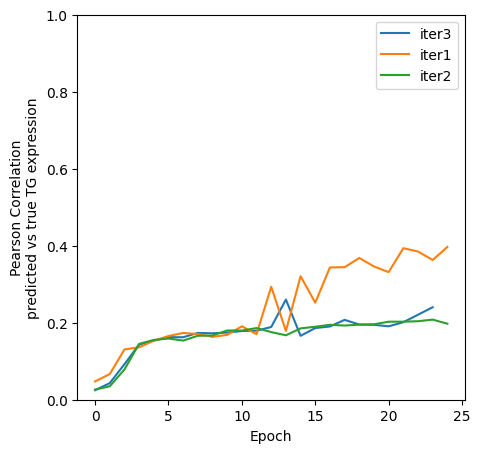

In [100]:
plt.figure(figsize=(5,5))

for iter_name, iter_train_df in iter_log_dict.items():
    plt.plot(iter_train_df.index, iter_train_df["Pearson"], label=iter_name)

plt.xlabel("Epoch")
plt.ylabel("Pearson Correlation\npredicted vs true TG expression")
plt.ylim((0, 1))
plt.legend()
plt.show()

In [19]:
chip_df = pd.read_csv(GROUND_TRUTH_FILE, header=0, index_col=None)
chip_edges = set(zip(chip_df["Gene1"].str.upper(), chip_df["Gene2"].str.upper()))

In [22]:
tf_tg_pred = pd.read_csv(os.path.join(TEST_DIR, "tf_tg_classifier_predictions.csv"), header=0, index_col=None)
tf_tg_pred.head()

,TF,TG,probability,label
0,Amyb,1110059E24Rik,0.0,0
1,Amyb,1700054A03Rik,0.0,0
2,Amyb,4430402I18Rik,0.0,0
3,Amyb,4930481A15Rik,0.0,0
4,Amyb,4930505N22Rik,0.0,0


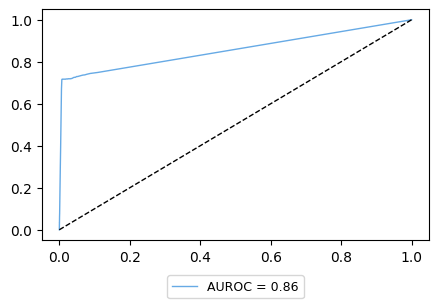

In [44]:
from dev.notebooks.plotting import (
    plot_true_false_distribution, plot_true_false_boxplots, plot_true_false_scores_by_tf_boxplots,
    plot_true_false_scores_by_tf_barplots
)


fig = plot_auroc(tf_tg_pred, score_col="probability")
fig.show()

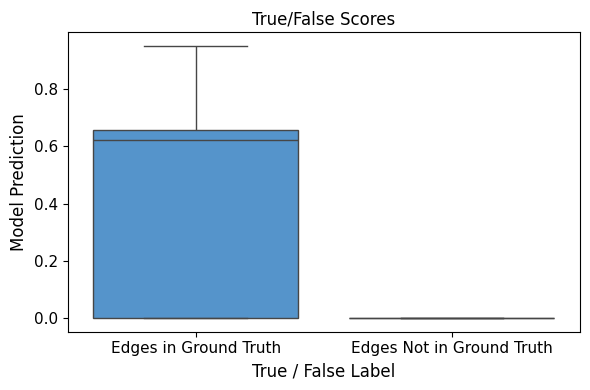

In [38]:
fig = plot_true_false_boxplots(
    df=tf_tg_pred,
    score_col="probability",
    xlabel="True / False Label",
    ylabel = "Model Prediction"
    )

In [53]:
tf_tg_pred_bool = tf_tg_pred.copy()
tf_tg_pred_bool["label"] = tf_tg_pred_bool["label"].astype(bool)
tf_tg_pred_bool.head()

,TF,TG,probability,label
0,Amyb,1110059E24Rik,0.0,False
1,Amyb,1700054A03Rik,0.0,False
2,Amyb,4430402I18Rik,0.0,False
3,Amyb,4930481A15Rik,0.0,False
4,Amyb,4930505N22Rik,0.0,False


In [54]:
print(tf_tg_pred_bool.head())

     TF             TG  probability  label
0  Amyb  1110059E24Rik          0.0  False
1  Amyb  1700054A03Rik          0.0  False
2  Amyb  4430402I18Rik          0.0  False
3  Amyb  4930481A15Rik          0.0  False
4  Amyb  4930505N22Rik          0.0  False


In [56]:
sub = tf_tg_pred_bool[["probability", "TF", "label"]].dropna().copy()
sub["label"] = sub["label"].astype(bool)